In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sys
import statsmodels.api as sm

## Versions

In [2]:
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Sklearn', sklearn))

print("Python version:", sys.version, '\n')
for lib in libraries:
    print('{0} version: {1}'.format(lib[0], lib[1].__version__))

Python version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 14:00:49) [MSC v.1915 64 bit (AMD64)] 

Matplotlib version: 3.1.0
Numpy version: 1.16.4
Sklearn version: 0.21.2


## Introduction

We left off last time discussing the basics of Linear Regression. Specifically, we learned key terminology and how to find parameters for both univariate and multivariate Linear Regression. Now we'll turn our focus to metrics about our model. 

We'll look at the following key metrics:
1. Sum of Squared Errors (SSE)
2. Total Sum of Squares (SST)
3. $R^{2}$
4. adj $R^{2}$

To keep things simple, we'll use the univariate baby weight data from the previous notebook and leverage sklearn to find the model parameters.

#### Simulate Data

In [3]:
# reproducibility
np.random.seed(10)

# generate data
babies = range(10)
months = np.arange(13)
data = [(month, np.dot(month, 24.7) + 96 + np.random.normal(loc=0, scale=20))
        for month in months
        for baby in babies]
month_data = [element[0] for element in data]
weight_data = [element[1] for element in data]

#### Fit Data

In [4]:
from sklearn.linear_model import LinearRegression

X = np.array(month_data).reshape(-1,1)
y = weight_data

lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Technical note: X contains .reshape(-1,1) which creates a fake 2D object for fitting. This trick pops up quite frequently so you should remember it.

#### Plot Data

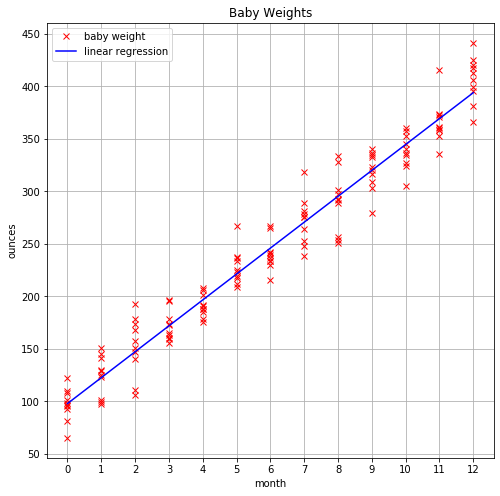

In [5]:
model = lr.predict(months.reshape(-1,1))

plt.figure(figsize=(8,8))
plt.plot(month_data, weight_data, 'rx', label='baby weight')
plt.plot(months, model, 'b', label='linear regression')
plt.title('Baby Weights')
plt.xlabel('month')
plt.ylabel('ounces')
plt.xticks(months)
plt.legend()
plt.grid();

## Metrics to Assess Model

We will investigate four key metrics:

1. Sum of Squared Errors (SSE)
2. Total Sum of Squares (SST)
3. $R^{2}$ 
4. adj $R^{2}

First, the formulas. Keep in mind that $y$ is the `observed value` whereas $\hat{y}$ is the `predicted value`. Here, *m* represents the `total number of observations`. For example, if there are 25 baby weigths, then m equals 25. Lastly, $df_{t}$ is the degrees of freedom of the estimate of the population variance of the dependent variable and $df_{e}$ is the degrees of freedom of the estimate of the underlying population error variance. 

$SSE = \sum_{i=1}^{m} {(y_{i} - \hat{y_{i}})^{2}}$ 

$SST = \sum_{i=1}^{m} (y - \bar{y})^{2}$

$R^{2} = 1 - \frac{SSE}{SST}$

adj $R^{2} = 1 - \frac{SSE*df_{t}}{SST*df_{e}}$

---

I'm going to assume you familiar with basic OOP. If not, you should still get the main idea, though some nuances may be lost. 

Without further ado, let's create a class to capture the four key statistics about our data. 

In [9]:
X.shape[0] - 1 

129

In [13]:
X.shape[0] - X.shape[1] - 1 

128

In [14]:
class Stats:
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        ## degrees of freedom population dep. variable variance
        self._dft = X.shape[0] - 1   
        ## degrees of freedom population error variance
        self._dfe = X.shape[0] - X.shape[1] - 1  
    
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - self.sse()/self.sst()
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)

While we're at it, let's create a pretty print function to generate a nice looking report.

In [15]:
def pretty_print_stats(stats_obj):
    '''returns report of statistics for a given model object'''
    items = ( ('sse:', stats_obj.sse()), ('sst:', stats_obj.sst()), 
             ('r^2:', stats_obj.r_squared()), ('adj_r^2:', stats_obj.adj_r_squared()) )
    for item in items:
        print('{0:8} {1:.4f}'.format(item[0], item[1]))

#### Report on Model

In [16]:
stats = Stats(X, y, lr)
pretty_print_stats(stats)

sse:     50253.0180
sst:     1158834.2148
r^2:     0.9566
adj_r^2: 0.9563


#### Interpretation

**SSE** is measure of how far off our model's predictions are from the observed values. A value of 0 indicates perfect predictions. A non-zero value indicates errors. We expect a non-zero value. Why? Because there is almost always irreducible error that we just can't get around unless we're dealing with some trivial problem. 

**Keep in mind the errors are squared**

*Why is that?*

Answer: squaring the values makes them all positive. If we didn't square them, then we'd have some positive and some negative values. No matter how you slice it, you end up with error that looks smaller than it is in reality. 

*But why not use absolute error instead of squared error?*

If you think about what squaring does to large numbers you'll realize that we're really penalizing large errors. A single point that deviates from the general trend can cause large squared errors. These anomalous points are called outliers. Much more on this in the next notebook.

---

**SST** is a measure of the variance in the target variable. It is measured simply as the sum of each observation from the target mean.

---

**$R^{2}$** measures how much variance is captured by the model. The range for Ordinary Least Squares is [0,1]. It is possible to get negative values for $R^{2}$ but that would require a fitting procedure other than OLS or non-linear data. 

---

**Adjusted $R^{2}$** is the same as standard $R^{2}$ except that it penalizes models when additional features are added. This naturally leads to the next section about why $R^{2}$ is a poor metric to use.

## Why $R^{2}$ is a Poor Metric

$R^{2}$ will only go up as additional features are added, even if they provide the model no new predictive power. See the example below.

#### Generate Dummy Data

In [9]:
def generate_random_data(num_rows, num_features, random_state=None):
    '''returns 2D numpy based on user-defined inputs with random features.'''
    if random_state:
        np.random.seed(random_state)
    for feature in range(num_features):
        if feature == 0:
            data = np.random.uniform(size=num_rows)
        elif feature == 1:
            data = np.hstack((data.reshape(-1,1),
                              np.random.uniform(size=num_rows).reshape(-1,1)))
        else:
            data = np.hstack((data, np.random.uniform(size=num_rows).reshape(-1,1)))
    return data

In [10]:
min_features = 1
max_features = 100

r_squared = []
adj_r_squared = []

y = generate_random_data(num_rows=200, num_features=1, random_state=99)

for features in range(min_features, max_features+1):
    X = generate_random_data(num_rows=200, num_features=features, random_state=101)
    results = sm.OLS(y, X).fit()
    r_squared.append(results.rsquared)
    adj_r_squared.append(results.rsquared_adj)

#### Plot Varying Number of Features

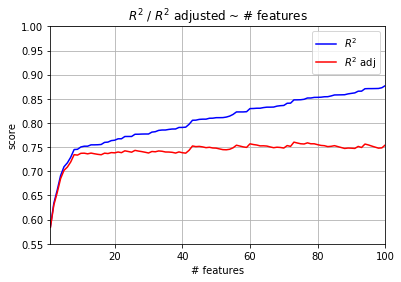

In [11]:
plt.plot(np.arange(1,101), r_squared, color='blue', label='$R^2$')
plt.plot(np.arange(1,101), adj_r_squared, color='red', label='$R^2$ adj')
plt.title('$R^2$ / $R^2$ adjusted ~ # features')
plt.xlabel('# features')
plt.ylabel('score')
plt.xlim(1,100)
plt.ylim(0.55, 1)
plt.legend()
plt.grid();

Ouch! That's bad news. We generated random data. There's absolutely no reason why including more features should lead to a better model. Yet, it's clear from the plot above that $R^{2}$ only increases under these conditions. However, **Adjusted $R^{2}$** levels out because of the penalty involved. 

The big takeaway here is that you cannot compare two Linear Regression models with differing numbers of features using $R^{2}$ alone. It just cannot be done. Adjusted $R^{2}$ works, though.

## Wrap Up

As we'll see later on, there are better ways to assess machine learning models, namely in-sample vs out-of-sample metrics and cross-validation. More on those in a future post about train/test split and cross-validation.

Next time we'll dive into Linear Regression assumptions, pitfalls, and ways to address problems.